# Simple exam with D = infinity

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# define card values
card_val = {'A': 11, 'K': 10, 'Q': 10, 'J': 10, 't': 10, '9': 9,
            '8': 8, '7': 7, '6': 6, '5': 5, '4': 4, '3': 3, '2': 2, '1': 1, '': 0, '0': 0}


In [3]:

def card_gen():
    '''
    Returns a random card.
    '''
    # cant use 10 because only one digit allowed in np string array. Using t instead
    poss_cards = ['A', 'K', 'Q', 'J', 't', 9, 8, 7, 6, 5, 4, 3, 2]
    loc = np.random.randint(0, len(poss_cards))
    return str(poss_cards[loc])


In [4]:

def sum_cards(cards):
    '''
    function to get the score of the hand.

            Parameters:
                    cards (array): all the cards in the current hand

            Returns:
                    the score of the hand
    '''
    y = 1
    tem_cards = np.copy(np.array((cards)))

    while y == 1:
        total = 0
        for x in tem_cards:
            total += card_val[x]
        if total <= 21:
            # score of hand
            return sum([card_val[tem_cards[k]] for k in range(len(tem_cards))])**2
        elif np.any(tem_cards == 'A'):
            total = total-10

            tem_cards[np.where(tem_cards == 'A')[0][0]] = '1'

        else:
            return 0


In [5]:

def eps_greed_pol(state, total, eps, Qtab_0, Qtab_1):
    '''
    Epsilon greedy policy.

            Parameters:
                    state (array): all the cards in the current hand
                    total (int): The total value of the current hand
                    eps (float): The value of epsilon
                    Qtab_0 (dict): The Qtable for the action of sticking
                    Qtab_1 (dict): The Qtable for the action of hitting

            Returns:
                    The action of the agent following this policy
    '''

    exploration = np.random.choice(np.arange(0, 2), p=[1-eps, eps])
    useable_ace = int(np.any(state == 'A'))
    com_state = tuple([total, useable_ace])
    # choose at random if state not been visited
    if (com_state not in Qtab_1) and (com_state not in Qtab_0):
        action = np.random.choice(np.arange(0, 2), p=[0.5, 0.5])
        Qtab_1[com_state] = 0
        Qtab_0[com_state] = 0

    elif com_state not in Qtab_1:  # action 1 has not been selected before
        Qtab_1[com_state] = 0
        if exploration == 1:
            action = 1
        else:
            action = 0

    elif com_state not in Qtab_0:  # action 0 has not been selected before
        Qtab_0[com_state] = 0
        if exploration == 1:
            action = 0
        else:
            action = 1
    # choose highest Q value if exploration==0
    elif Qtab_1[com_state] > Qtab_0[com_state]:
        if exploration == 1:
            action = 0
        else:
            action = 1

    elif Qtab_1[com_state] == Qtab_0[com_state]:
        action = np.random.choice(np.arange(0, 2), p=[0.5, 0.5])
    else:  # condition for when Qtable0<Qtable1
        if exploration == 1:
            action = 1
        else:
            action = 0

    return action


In [6]:
# runs episodes
def run_episodes(num_eps, policy, eps, Qtab_0, Qtab_1, per_hand_decay, Q_learn, alpha, alpha_decay):
    '''
    Runs an number of episodes of the blackjack environment.

            Parameters:
                    num_eps (int): The number of hands played
                    policy (function): The policy being followed in the episodes
                    eps (float): The value of epsilon
                    Qtab_0 (dict): The Qtable for the action of sticking
                    Qtab_1 (dict): The Qtable for the action of hitting
                    Per_hand_decy (float): How much epsilon is decayed per hand
                    Qlearn (Boolean): True if Qlearning is being used
                    Alpha (float): Value of alpha for Qlearning
                    alpha_decay (floar): The decay rate of alpha

            Returns:
                    The totals,actions,rewards and cards from the episodes
    '''

    # useful to keep track of these 4 for debugging
    TOTAL = np.zeros([num_eps, 12])
    action = np.zeros([num_eps, 12])
    reward = np.zeros([num_eps, 12])
    cards = np.zeros([num_eps, 12], dtype=str)

    for i in range(num_eps):
        if Q_learn == True:
            eps = eps*per_hand_decay
            alpha = alpha*alpha_decay
        total = 0
        bust = False
        while bust != True:
            # if no cards in hand must twist

            if cards[i, 0] == '':
                j = 0
                cards[i, j] = card_gen()
                total = card_val[cards[i, j]]
                TOTAL[i, j] = total

            # random action 0 = stick, 1 = twist
            choice = policy(cards[i, :], total, eps, Qtab_0, Qtab_1)
            action[i, j] = choice

            if choice == 0:
                reward[i, j] = sum_cards(cards[i, :])
                if Q_learn == True:
                    useable_ace = int(np.any(cards[i, :] == 'A'))

                    com_state = tuple([total, useable_ace])

                    # update using temporal difference equations
                    Qtab_0[com_state] = Qtab_0[com_state] + \
                        alpha*(reward[i, j]-Qtab_0[com_state]
                               )  # note qmax=0 as its a terminal state
                break
            else:
                j += 1
                cards[i, j] = card_gen()

                total = sum_cards(cards[i, :])
                TOTAL[i, j] = total

                if Q_learn == True:
                    prev_useable_ace = int(np.any(cards[i, 0:j] == 'A'))
                    now_useable_ace = int(np.any(cards[i, :] == 'A'))
                    # using past total
                    com_state = tuple([TOTAL[i, j-1], prev_useable_ace])
                    # using current toal
                    qmax = Qmax(tuple([total, now_useable_ace]))

                    # update qvalue using temporal difference
                    Qtab_1[com_state] = Qtab_1[com_state] + alpha * \
                        (qmax-Qtab_1[com_state])  # note reward = 0

            if total == 0:  # check if bust
                bust = True

    return cards, TOTAL, action, reward


In [7]:
# update qtables
def update_qtables(cards, rewards, actions, total):
    '''
    Updates the Qtables using the data from the episodes.

            Parameters:
                    cards (array): all the cards from the episodes
                    rewards (array): all the rewards from the episodes
                    actions (array): all the actions from the episodes
                    total (array): all the totals from the episodes
                    

            Returns:
                    None
    '''
    # Qtable 0
    for row in range(len(cards)):
        sorted_hand = cards[row, :]
        loc_last_card = np.where(sorted_hand == '')[0][0]-1
        Qtable_0[tuple([total[row, loc_last_card], int(
            np.any(sorted_hand == 'A'))])] = rewards[row, loc_last_card]
    # Qtable 1
    for col in range(0, len(cards[0, :])):  # iterate through columns
        # only consder when actions==1
        sorted_hands = cards[actions[:, col] == 1, 0:col+1]
        sorted_rewards = rewards[actions[:, col] == 1, :]
        sorted_totals = total[actions[:, col] == 1, col]
        indv = np.unique(sorted_totals, axis=0)  # unique totals

        for tot in indv:
            locs = np.where(sorted_totals == [tot])
            useable_ace = int((np.any(sorted_hands[locs, :] == 'A')) or np.any(
                sorted_hands[locs, :] == '1'))
            # take average of all returns from same state
            if tuple([tot, useable_ace]) not in counter:
                counter[tuple([tot, useable_ace])] = len(locs[0])
            if tuple([tot, useable_ace]) not in Qtable_1:
                Qtable_1[tuple([tot, useable_ace])] = sum(
                    (np.max(sorted_rewards[locs[0], :], axis=1)))/len(locs[0])  # new mean
            else:
                Qtable_1[tuple([tot, useable_ace])] = (Qtable_1[tuple([tot, useable_ace])]*counter[tuple([tot, useable_ace])] + sum(
                    (np.max(sorted_rewards[locs[0], :], axis=1))))/(len(locs[0])+counter[tuple([tot, useable_ace])])  # find the new mean ie : ((mean(old))*num(old)+sum(new))/(num(old)+num(new))= (sum(old)+sum(new))/(num(old)+num(new))=mean
                counter[tuple([tot, useable_ace])] += len(locs[0])
    return


In [8]:
# iterates between running episodes and updating q values
def policy_iter_loop(update_qtables, eps_greed_pol, eps, iters, per_deck_decay, per_hand_decay):
    '''
    Performs the policy iteration cycle.

            Parameters:
                    update_qtables (function): function to update Qtables
                    eps_greed_pol (function): policy function
                    eps (float): value of epsilon
                    iters (int): number of policy iterations
                    per_deck_decay (float): epsilon decay per deck
                    per_hand_decay (float): epsilon decay per hand
                    

            Returns:
                    the average reward achieved by the agent per 10000 hands
    '''


    avg_reward = np.zeros([1, iters])

    for it in range(iters):
        cards, total, actions, rewards = run_episodes(
            10000, eps_greed_pol, eps, Qtable_0, Qtable_1, per_hand_decay, False, 0, 0)  # approx the qvalues
        update_qtables(cards, rewards, actions, total)  # update the qvalues
        total = 0
        for x in range(len(cards)):
            loc_last_card = np.where(cards[x, :] == '')[0][0]-1
            # can use this or simply the max of each row, given rewards are only given at the final state
            total += rewards[x, loc_last_card]
        avg_reward[0, it] = total/len(cards)
        if per_hand_decay != False:
            eps = eps*per_hand_decay**10000
        else:
            eps = eps*per_deck_decay  # update decay for input into next loop

    return avg_reward


In [9]:
Qtable_0 = {}
Qtable_1 = {}
counter = {}
iters = 100
per_hand_decay = 1  # no decay
per_deck_decay = 1

avg_rew1 = policy_iter_loop(
    update_qtables, eps_greed_pol, 0.1, iters, per_deck_decay, per_hand_decay)


In [10]:
Qtable_0 = {}
Qtable_1 = {}
counter = {}
per_hand_decay = 0.999994  # decaying each hand work better than per deck
per_deck_decay = 1
iters = 100
avg_rew2 = policy_iter_loop(
    update_qtables, eps_greed_pol, 1, iters, per_deck_decay, per_hand_decay)


238.5508
282.3329


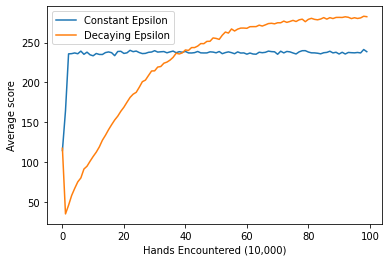

In [11]:
plt.plot(range(len(avg_rew1[0])), avg_rew1[0], label='Constant Epsilon')
plt.plot(range(len(avg_rew2[0])), avg_rew2[0], label='Decaying Epsilon')
plt.xlabel('Hands Encountered (10,000)')
plt.ylabel('Average score')
plt.legend()
print(avg_rew1[0][-1])
print(avg_rew2[0][-1])


## Dynamic programming

In [12]:
import itertools as it


In [13]:
# returns combinations of cards
def all_hands(cards, num_cards):
    '''
    Get alls possible combinations of cards.

            Parameters:
                    cards (array): all the possible cards
                    num_cards (int): the number of cards for combinations
                    

            Returns:
                    all the possible combinations of the cards
    '''
    x = it.combinations_with_replacement(cards, num_cards)
    return x


In [14]:
# initialize q table
cards = ['A', 'K', 'Q', 'J', 't', '9', '8', '7', '6', '5', '4', '3', '2']
Qtable_0_2 = {}
Qtable_1_2 = {}
num_cards = 8  # top number of cards for combinations
for y in range(num_cards, 0, -1):  # start at 8
    cards_com = all_hands(cards, y)  # all combinations of 8 cards
    for x in cards_com:
        # use cards as states not total, this helps with back propagating rewards and also is useful for task 2
        sorted = tuple(np.sort(x))
        Qtable_0_2[sorted] = sum_cards(x)
    if y < num_cards:  # for card combinatins less than 8
        cards_com = all_hands(cards, y)
        for x in cards_com:
            sorted = tuple(np.sort(x))
            total = 0
            for card in cards:
                sorted_com = tuple(np.sort(sorted+(card,)))
                if sorted_com in Qtable_1_2:
                    q1val = Qtable_1_2[sorted_com]
                else:
                    q1val = 0
                if sorted_com in Qtable_0_2:
                    q0val = Qtable_0_2[sorted_com]
                else:
                    q0val = 0
                # back propagate returns using bellman equations
                total += max(q1val, q0val)
                Qtable_1_2[sorted] = total/len(cards)


In [15]:
# greedy policy
def dynam_prog_pol(cards, eps, total, Qtab_0, Qtab_1):
    '''
    greedy policy that is followed by dynamic programming agent.

            Parameters:
                    cards (array): all the cards in the hand
                    epsilon (float): epsilon value (redundant in this function but needed for other policy and to allow both methods to be used in run episodes function)
                    total (int): the current score of the hand
                    Qtab_0 (dict): The Qtable for the action of sticking
                    Qtab_1 (dict): The Qtable for the action of hitting
                    

            Returns:
                    the action taken by the agent while following a greedy policy
    '''
    cards = np.array([x for x in cards if x != ''])
    loc = cards == '1'
    cards[loc] = 'A'  # convert 1s back to aces
    if Qtab_1[tuple(np.sort(cards))] > Qtab_0[tuple(np.sort(cards))]:
        return 1
    else:
        return 0


In [16]:
cards, total, actions, rewards = run_episodes(
    10000, dynam_prog_pol, 1, Qtable_0_2, Qtable_1_2, 1, False, 0, 0)  # approx the qvalues, only relevant parameters are Qtables and policy


In [17]:
# take the max of the each row of the rewards (reward row is all 0s except if sticking) then average
dynam_avg_score = np.mean(np.max(rewards, 1))
print(dynam_avg_score)


286.7323


## Q-learning (off policy TD control)

In [18]:
def Qmax(key):
    if key in Qtable_1_3 and key in Qtable_0_3:
        return max(Qtable_1_3[key], Qtable_0_3[key])
    elif key not in Qtable_1_3 and key not in Qtable_0_3:
        return 0
    elif key not in Qtable_1_3:
        return Qtable_0_3[key]
    else:
        return Qtable_1_3[key]


In [19]:
Qtable_1_3 = {}
Qtable_0_3 = {}
per_hand_decay = 0.999994
alpha_decay = 1
alpha = 0.05
its = 1000000
eps = 1

cards, TOTAL, action, reward = run_episodes(
    its, eps_greed_pol, eps, Qtable_0_3, Qtable_1_3, per_hand_decay, True, alpha, alpha_decay)  # approx the qvalues


avg = []
for n in range(int(its/10000)):  # average the score over every 10,000 iterations
    avg.append(np.mean(np.max(reward[n*10000:(n+1)*10000, :], axis=1)))


In [20]:
Qtable_1_3 = {}
Qtable_0_3 = {}
decay = 0.999994
alpha = 2
alpha_decay = 0.99999
its = 1000000

cards, TOTAL, action, reward = run_episodes(
    its, eps_greed_pol, eps, Qtable_0_3, Qtable_1_3, per_hand_decay, True, alpha, alpha_decay)  # approx the qvalues

avg_decay_alpha = []
for n in range(int(its/10000)):  # average the score over every 10,000 iterations
    # take the mean of the max rewards in each row per 10,0000 rows
    avg_decay_alpha.append(
        np.mean(np.max(reward[n*10000:(n+1)*10000, :], axis=1)))


276.2508
283.6293


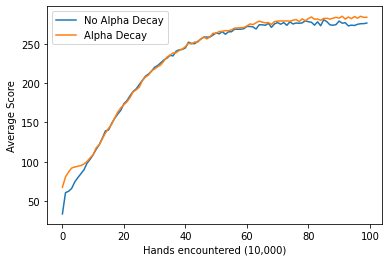

In [21]:
plt.plot(avg, label='No Alpha Decay')
plt.plot(avg_decay_alpha, label='Alpha Decay')
plt.xlabel('Hands encountered (10,000)')
plt.ylabel('Average Score')
plt.legend()
print(avg[-1])
print(avg_decay_alpha[-1])


## compare all methods

Text(0, 0.5, 'Average Score')

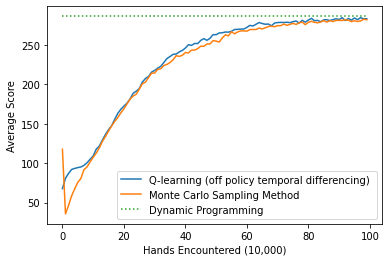

In [22]:
plt.plot(avg_decay_alpha, label='Q-learning (off policy temporal differencing) ')
plt.plot(avg_rew2[0], label='Monte Carlo Sampling Method')
plt.plot([dynam_avg_score]*100, linestyle='dotted',
         label='Dynamic Programming')
plt.legend()
plt.xlabel('Hands Encountered (10,000)')
plt.ylabel('Average Score')


# Finite number of decks

In [23]:

def make_inital_shuffled_deck(decks, seed):
    '''
    Takes n decks of cards and shuffles them given a seed, seed is for reproduceability.

            Parameters:
                    decks (int): number of decks being used
                    seed (int): the numpy random seed
                    

            Returns:
                    the shuffled deck
    '''
    # cant use 10 because only one digit allowed in np string array
    poss_cards = ['A', 'K', 'Q', 'J', 't',
                  '9', '8', '7', '6', '5', '4', '3', '2']
    np.random.seed(seed)
    cards = list(np.repeat(poss_cards, decks*4))
    np.random.shuffle(cards)  # shuffles in place
    return cards


In [24]:

def card_gen2(cards):
    '''
    Takes first element out of a shuffled deck.

            Parameters:
                    cards (array): shuffled deck
                
            Returns:
                    the first card from the deck and the remaining deck
    '''
    
    if cards == []:
        return 0, cards
    out = cards.pop(0)
    return out, cards


In [25]:

def make_q_table(history, decks, num_cards, deck_remaining, start):
    '''
    Makes q tables given a history of cards.

            Parameters:
                    history (array): the cards already been played
                    decks (int): the number of decks being used
                    num_cards (int): the number of cards used for combinations
                    deck_remaining (array): the remaing deck
                    start (binary): 1 if it is the first time the function is called
                
            Returns:
                    None
    '''

    cards = ['A', 'K', 'Q', 'J', 't', '9', '8', '7', '6', '5', '4', '3', '2']
    history[np.where(history == '1')] = 'A'  # change 1 back to ace for Qtables

    num_cards_used = len(np.where(history != '')[0])
    # only consider relevant card combinations
    num_cards = min(num_cards, 52*decks-num_cards_used)
    for y in range(num_cards, 0, -1):  # start at top and backpropagate

        cards_com = all_hands(cards, y)

        for x in cards_com:
            sorted = tuple(np.sort(x))
            if start == 1:
                # make Qtable0 only first time this is run, as this never changes
                Qtable_0_4[sorted] = sum_cards(x)
        if y < num_cards:  # back propagation
            cards_com = all_hands(cards, y)

            for x in cards_com:
                sorted = tuple(np.sort(x))
                temp_deck_remain = np.copy(
                    deck_remaining)  # store tempory deck
                not_in_deck = 'False'
                # remove card com x from cards remaining
                for k in x:

                    loc = np.where(np.array(temp_deck_remain) == k)

                    if loc[0].size == 0:
                        not_in_deck == True
                        break  # break out of first for loop

                    # remove cards for remaining deck, so only consider relevant combinations, ie: if one is considering the policy for hand ['2'] and there is only one 2 in the deck the hand ['2','2'] should not be backpropagted as its not possible
                    temp_deck_remain[loc[0][0]] = ''
                if not_in_deck == True:
                    break  # break out of second for loop
                # see which cards are left
                cards_left = np.unique(
                    temp_deck_remain[temp_deck_remain != ''])

                total = 0
                for card in cards_left:
                    # consider all possibe future states
                    sorted_com = tuple(np.sort(sorted+(card,)))
                    if sorted_com in Qtable_1_4:
                        q1val = Qtable_1_4[sorted_com]
                    else:
                        q1val = 0
                    if sorted_com in Qtable_0_4:
                        q0val = Qtable_0_4[sorted_com]
                    else:
                        q0val = 0
                    prob_card = (
                        decks*4-len(np.where(history == card)[0]))/(decks*52-num_cards_used)  # transition probability

                    total += prob_card*max(q1val, q0val)
                    Qtable_1_4[sorted] = total
    return


In [26]:

def limited_decks(policy, decks, num_cards, memory_agent, seed, n):

    '''
    Runs an episode for the limited decks environment,seperate function to unlimited decks to make it easier to understand.

            Parameters:
                    policy (function): the policy being followed
                    decks (int): the number of decks being used
                    num_cards (int): the number of cards used for combinations
                    memory_agent (binary): 1 if a memory agent is being used
                    seed (int): the numpy random seed
                
            Returns:
                    the cards,totals,rewards and actions from the episode
    '''



    # initialiaze assuming each hand is 2 cards, should not run out of rows
    num_hands = int(52*decks/2)
    TOTAL = np.zeros([num_hands, 12])
    action = np.zeros([num_hands, 12])
    reward = np.zeros([num_hands, 12])
    cards = np.zeros([num_hands, 12], dtype=str)
    full_deck = make_inital_shuffled_deck(decks, seed)  # initialize deck

    i = 0
    while full_deck != []:  # iterate while deck mix is not empty

        if memory_agent == 1:

            if i == 0:
                # only make Qtable0 on first run
                make_q_table(cards, decks, num_cards, full_deck, start=1)
            elif i % n == 0:
                # if memory agent is being used make Qtable 1 every n hands
                make_q_table(cards, decks, num_cards, full_deck, start=0)

        total = 0
        bust = False
        while bust != True:  # if bust move to next hand

            # if no cards in hand must twist

            if cards[i, 0] == '':
                j = 0

                cards[i, j], full_deck = card_gen2(full_deck)

                if cards[i, j] == '0':
                    break  # break if deck is empty

                total = sum_cards(cards[i, :])
                TOTAL[i, j] = total  # track running total

            if memory_agent == 1:  # different qtables for each agent
                choice = policy(cards[i, :], False, False,
                                Qtable_0_4, Qtable_1_4)
            else:
                choice = policy(cards[i, :], False, False,
                                Qtable_0_2, Qtable_1_2)

            action[i, j] = choice  # track decision

            if choice == 0:
                reward[i, j] = sum_cards(cards[i, :])  # will return 0 if bust
                break
            else:
                j += 1
                cards[i, j], full_deck = card_gen2(full_deck)
                total = sum_cards(cards[i, :])
                reward[i, j] = 0  # no reward for hitting, only sticking
                TOTAL[i, j] = total  # track running total

                if cards[i, j] == '0':  # if deck is empty store hand score
                    reward[i, j] = total
                    break

            if total == 0:  # check if bust
                bust = True

        i += 1
    return cards, TOTAL, action, reward


In [27]:
Qtable_1_4 = {}
Qtable_0_4 = {}
cards, total, actions, rewards = limited_decks(
    dynam_prog_pol, 1, 6, 1, 100, 1)


In [28]:

# remove empty rows,(empty hands from intialization)
rew = rewards[np.where(cards[:, 1] != '')[0], :]
# can take the max as reards only given after sticking and 0 reward is given for bust
rew = np.max(rew, axis=1)
print(np.mean(rew))  # average rewards


309.42857142857144


## Compare with non memory agent

In [29]:
cards, total, actions, rewards = limited_decks(dynam_prog_pol, 1, 0, 0, 100, 1)


In [30]:
rew = rewards[np.where(cards[:, 1] != '')[0], :]
rew = np.max(rew, axis=1)
print(np.mean(rew))


296.76190476190476


## Compare over n deck seeds and n decks

In [31]:
Qtable_1_3 = {}
Qtable_0_3 = {}

seeds = [609, 100, 70009, 908, 33]  # seeds for reproduceability
decks = np.arange(1, 6)  # 1:5 decks
n = 1  # memory agent that makes a new Qtable 1 after every hand

mem_agent_rew = np.zeros([len(decks), len(seeds)])
non_mem_agent_rew = np.zeros([len(decks), len(seeds)])
for i in range(len(decks)):
    print(i)  # counter to track progress
    for j in range(len(seeds)):
        cards, total, actions, rewards = limited_decks(
            dynam_prog_pol, decks[i], 7, 1, seeds[j], n)
        mem_agent_rew[i, j] = np.mean(
            np.max(rewards[np.where(cards[:, 1] != '')[0], :], axis=1))  # condensed version of previous block
        cards, total, actions, rewards = limited_decks(
            dynam_prog_pol, decks[i], 0, 0, seeds[j], 10)
        non_mem_agent_rew[i, j] = np.mean(
            np.max(rewards[np.where(cards[:, 1] != '')[0], :], axis=1))  # condensed version of previous block


0
1
2
3
4


Text(0, 0.5, 'Average score difference between MA and NMA')

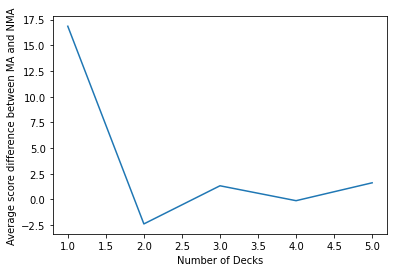

In [34]:
diff = mem_agent_rew-non_mem_agent_rew
plt.plot(decks, np.mean(diff, axis=1))
plt.xlabel('Number of Decks')
plt.ylabel('Average score difference between MA and NMA')
